# 1-bit Deutsch-Jozsa (XOR)

## Imports and Setup

In [1]:
# Standard Library Imports
import os
import re
import json
import random
import multiprocessing
from typing import Any, Tuple

# Third-party Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile,ClassicalRegister,QuantumRegister
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import QasmSimulator
from qiskit.visualization import plot_histogram
from IPython.display import display
from deap import creator, base, tools

import grape  # Grammatical evolution library
from grape import algorithms  # Evolutionary algorithms

In [2]:
# QiskitRuntimeService.save_account(channel="ibm_quantum", token="7a7db01ab67f2e9082827e16b71b7ca5230d0c4137133a0c9c28a70c96a12bfc92df1005263db0b17d7885549ea8326c9f04f6f3fb409ff08c633ebff8b59561", overwrite=True)

In [3]:
# Get the number of logical CPU cores available
num_cores = os.cpu_count()
print("Number of CPU cores available:", num_cores)

Number of CPU cores available: 8


In [4]:
BNF_GRAMMAR = grape.Grammar("grammars/xor.bnf")

In [5]:
SEED = 2526
random.seed(SEED)
np.random.seed(SEED)

In [6]:

def apply_oracle_constant0(qc): pass  # Does nothing

def apply_oracle_constant1(qc): qc.x(1)

def apply_oracle_balanced0to1(qc): qc.cx(0, 1)

def apply_oracle_balanced1to0(qc):
    qc.x(0)
    qc.cx(0, 1)
    qc.x(0)

ORACLES = {
    "constant0": apply_oracle_constant0,
    "constant1": apply_oracle_constant1,
    "balanced0to1": apply_oracle_balanced0to1,
    "balanced1to0": apply_oracle_balanced1to0
}

In [7]:
def get_measurement_probabilities(qc, shots=1024):
    simulator = QasmSimulator()
    job = simulator.run(qc, backend=simulator, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    return {outcome: count / shots for outcome, count in counts.items()}

def classify_circuit(probabilities, threshold=0.5):
    # Use the last bit of the outcome string to extract the measured value
    p_q0 = sum(p for o, p in probabilities.items() if o[-1] == '0')
    return "constant" if p_q0 >= threshold else "balanced"

def is_correct_classification(oracle_name, prediction):
    correct = "constant" if oracle_name.startswith("constant") else "balanced"
    return prediction == correct

In [8]:
class DJ1BitEvaluator:
    def __init__(self, shots=1024, threshold=0.5):
        self.shots = shots
        self.threshold = threshold
        self.oracles = ORACLES

    def decode_individual(self, ind):
        if ind.invalid or not hasattr(ind, 'phenotype'):
            return None
        try:
            code = ind.phenotype
            if isinstance(code, list): 
                code = ''.join(code)
            code = re.sub(r'\\n', '\n', code)
            code = re.sub(r'^"|"$', '', code)
            code = re.sub(r'"\s+"', '\n', code)
            return code
        except Exception as e:
            print(f"[Decode Error] {e}")
            return None

    def code_to_circuit(self, code_str):
        local_vars = {}
        try:
            exec(code_str, globals(), local_vars)
            return local_vars.get("qc")
        except Exception as e:
            print(f"Execution error: {e}")
            return None

    def evaluate(self, code_str):
        try:
            base_qc = self.code_to_circuit(code_str)
            if base_qc is None:
                return (float("inf"),)
        except Exception:
            return (float("inf"),)
        
        num_misses = 0
        max_error = 0.0

        # Loop over all oracles
        for name, oracle_fn in self.oracles.items():
            qc = base_qc.copy()
            oracle_fn(qc)
            probs = get_measurement_probabilities(qc, self.shots)
            
            # Classify based on the probability that qubit0 (rightmost bit) is measured as 0
            predicted = classify_circuit(probs, threshold=self.threshold)
            if not is_correct_classification(name, predicted):
                num_misses += 1

            # Compute probability that qubit0 is 0
            p_q0_0 = sum(prob for outcome, prob in probs.items() if outcome[1] == '0')
            error = (1.0 - p_q0_0) if name.startswith("constant") else p_q0_0
            if error > max_error:
                max_error = error

        # Return fitness as a tuple (number of misses + worst error)
        return (num_misses + max_error,)


In [9]:
POPULATION_SIZE    = 500
MAX_GENERATIONS    = 50
P_CROSSOVER        = 0.8     
P_MUTATION         = 0.1
ELITE_SIZE         = 1
HALLOFFAME_SIZE    = 1
CODON_SIZE         = 400
MAX_TREE_DEPTH     = 50      
TOURNAMENT_SIZE    = 7
MIN_INIT_DEPTH     = 9        
MAX_INIT_DEPTH     = 20       
CODON_CONSUMPTION  = "lazy"   
GENOME_REPRESENTATION='list'

# %%
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", grape.Individual, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("populationCreator", grape.sensible_initialisation,
    creator.Individual, bnf_grammar=BNF_GRAMMAR, min_init_depth=MIN_INIT_DEPTH,
    max_init_depth=MAX_INIT_DEPTH, codon_size=CODON_SIZE,
    codon_consumption=CODON_CONSUMPTION, genome_representation=GENOME_REPRESENTATION
)
toolbox.register("mate", grape.crossover_onepoint)
toolbox.register("mutate", grape.mutation_int_flip_per_codon)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

In [10]:
evaluator = DJ1BitEvaluator()

def evaluate(individual: Any, points_train=None) -> Tuple[float]:
    code_str = evaluator.decode_individual(individual)
    if not code_str:
        return (float("inf"),)
    return evaluator.evaluate(code_str)

toolbox.register("evaluate", evaluate)

gen = 0 , Best fitness = (0.484375,)
gen = 1 , Best fitness = (0.484375,) , Number of invalids = 62

[Generation 0] Best Fitness: 0.4844


/Users/caephas/Downloads/LERO/GE_QC/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:191: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


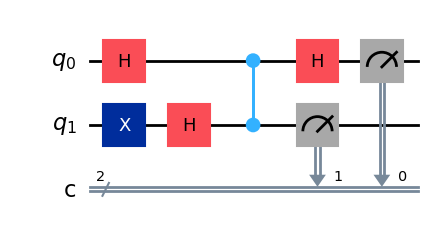

gen = 0 , Best fitness = (0.484375,)
gen = 1 , Best fitness = (0.484375,) , Number of invalids = 48

[Generation 1] Best Fitness: 0.4844


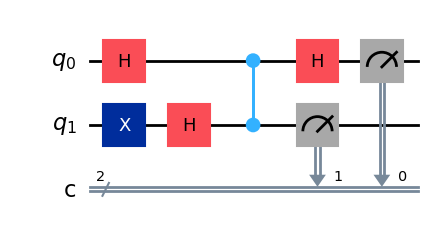

gen = 0 , Best fitness = (0.484375,)
gen = 1 , Best fitness = (0.484375,) , Number of invalids = 60

[Generation 2] Best Fitness: 0.4844


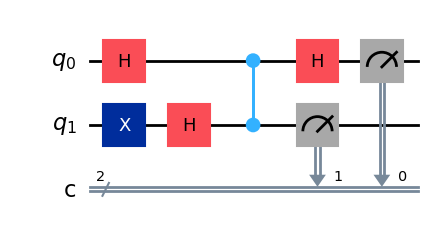

gen = 0 , Best fitness = (0.484375,)
gen = 1 , Best fitness = (0.4833984375,) , Number of invalids = 51

[Generation 3] Best Fitness: 0.4834


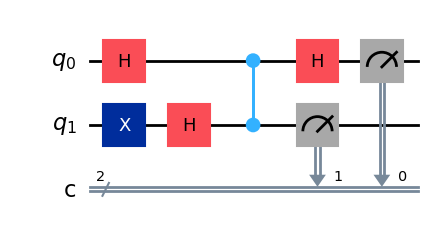

gen = 0 , Best fitness = (0.4833984375,)
gen = 1 , Best fitness = (0.4833984375,) , Number of invalids = 64

[Generation 4] Best Fitness: 0.4834


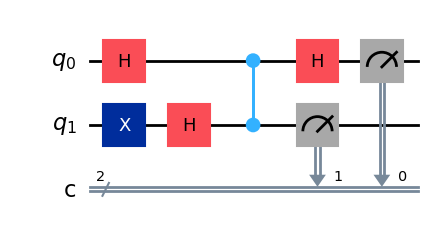

gen = 0 , Best fitness = (0.4833984375,)
gen = 1 , Best fitness = (0.4833984375,) , Number of invalids = 67

[Generation 5] Best Fitness: 0.4834


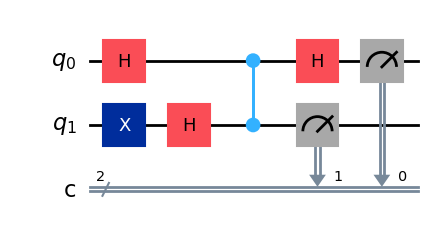

gen = 0 , Best fitness = (0.4833984375,)
gen = 1 , Best fitness = (0.4833984375,) , Number of invalids = 36

[Generation 6] Best Fitness: 0.4834


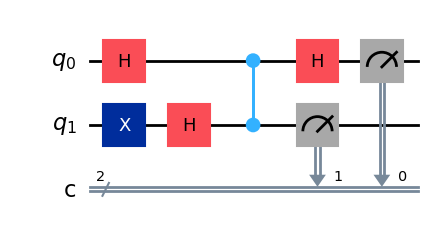

gen = 0 , Best fitness = (0.4833984375,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 33

[Generation 7] Best Fitness: 0.4805


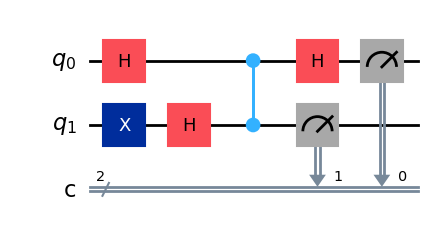

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 52

[Generation 8] Best Fitness: 0.4805


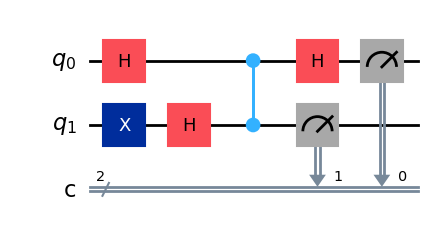

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 52

[Generation 9] Best Fitness: 0.4805


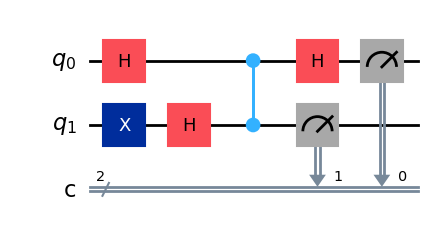

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 35

[Generation 10] Best Fitness: 0.4805


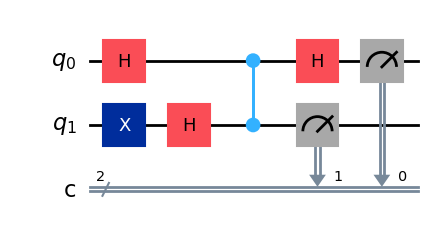

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 37

[Generation 11] Best Fitness: 0.4805


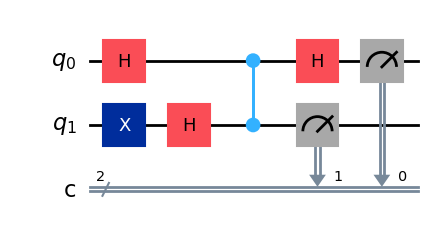

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 36

[Generation 12] Best Fitness: 0.4805


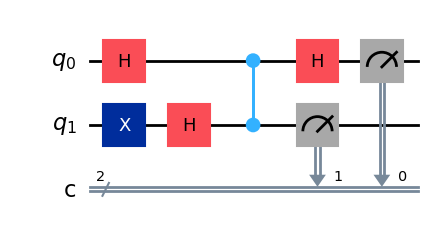

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 34

[Generation 13] Best Fitness: 0.4805


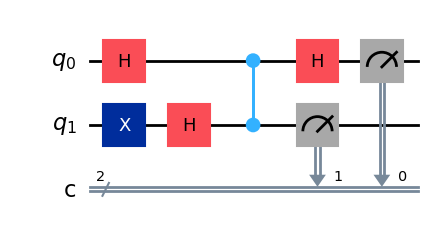

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 46

[Generation 14] Best Fitness: 0.4805


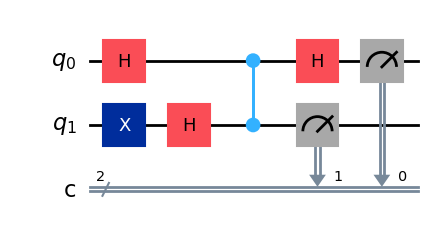

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 41

[Generation 15] Best Fitness: 0.4805


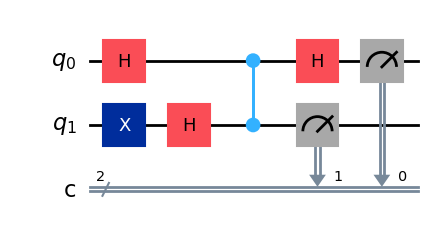

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 45

[Generation 16] Best Fitness: 0.4805


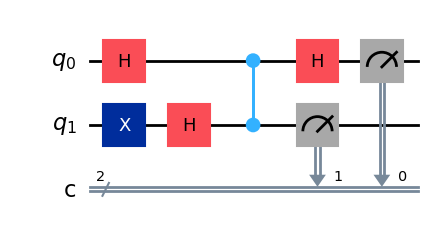

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 37

[Generation 17] Best Fitness: 0.4805


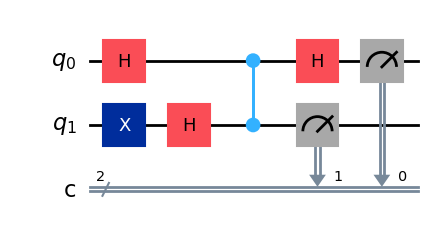

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 45

[Generation 18] Best Fitness: 0.4805


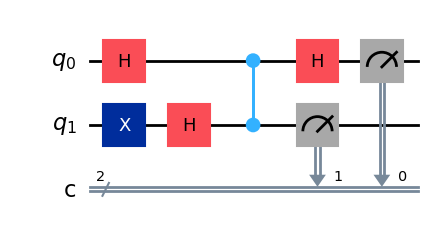

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 29

[Generation 19] Best Fitness: 0.4805


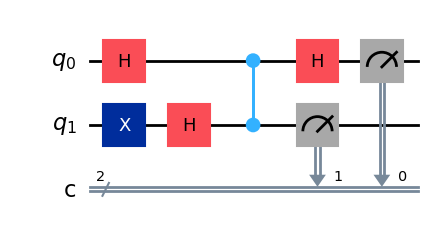

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 20

[Generation 20] Best Fitness: 0.4805


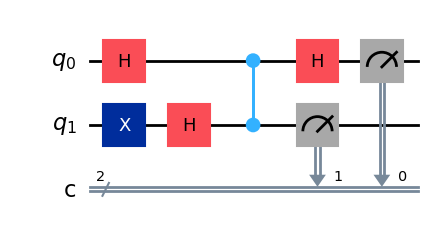

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 21

[Generation 21] Best Fitness: 0.4805


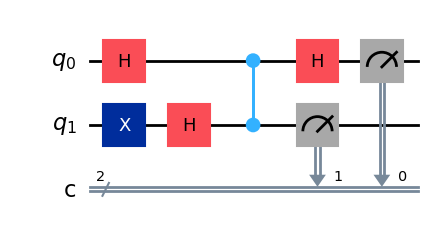

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 24

[Generation 22] Best Fitness: 0.4805


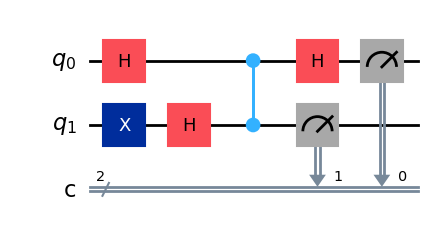

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 14

[Generation 23] Best Fitness: 0.4805


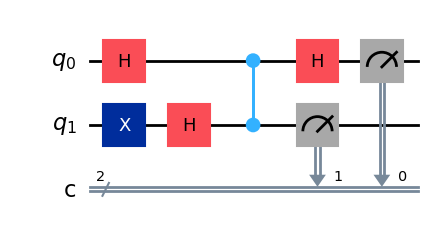

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 36

[Generation 24] Best Fitness: 0.4805


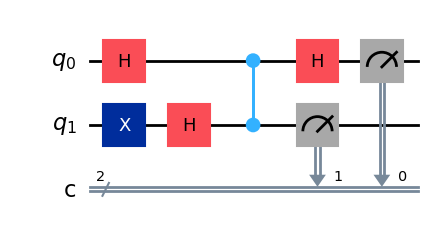

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 41

[Generation 25] Best Fitness: 0.4805


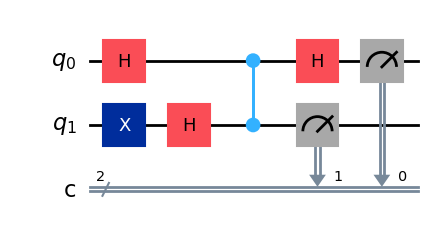

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 52

[Generation 26] Best Fitness: 0.4805


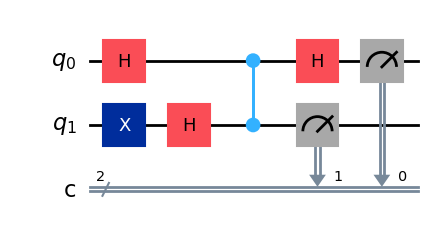

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 34

[Generation 27] Best Fitness: 0.4805


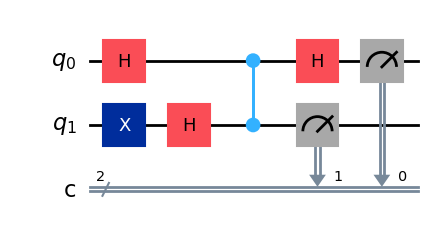

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 45

[Generation 28] Best Fitness: 0.4805


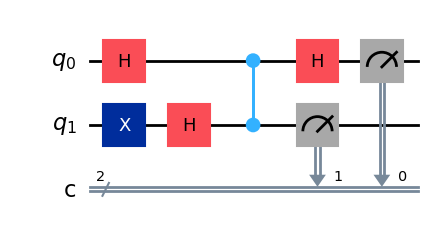

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 27

[Generation 29] Best Fitness: 0.4805


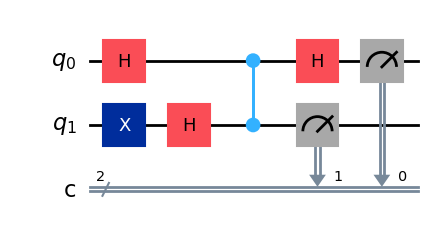

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 29

[Generation 30] Best Fitness: 0.4805


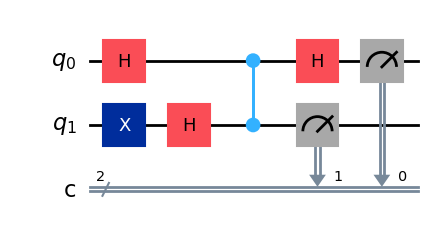

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 25

[Generation 31] Best Fitness: 0.4805


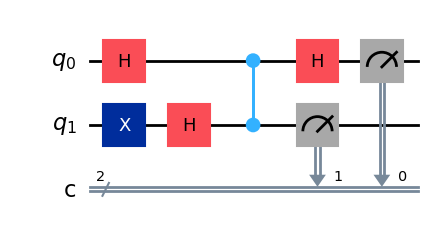

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 31

[Generation 32] Best Fitness: 0.4805


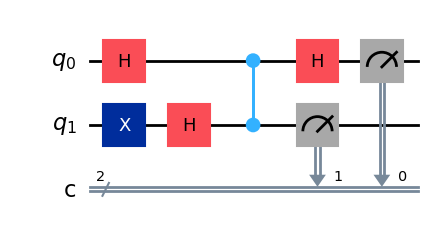

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 28

[Generation 33] Best Fitness: 0.4805


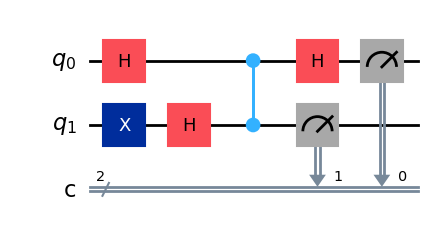

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 28

[Generation 34] Best Fitness: 0.4805


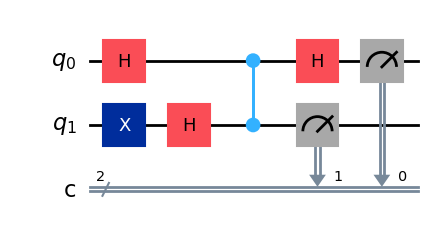

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 40

[Generation 35] Best Fitness: 0.4805


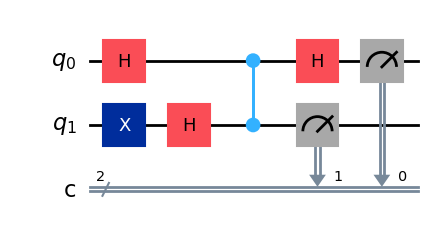

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 32

[Generation 36] Best Fitness: 0.4805


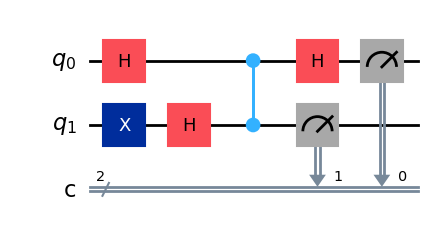

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 32

[Generation 37] Best Fitness: 0.4805


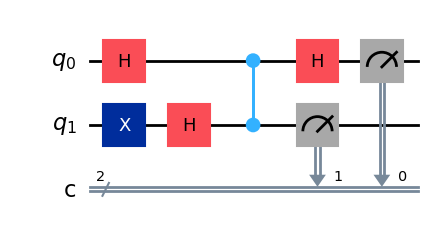

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 18

[Generation 38] Best Fitness: 0.4805


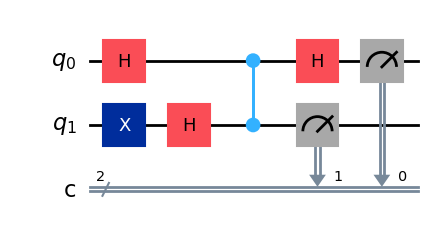

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 34

[Generation 39] Best Fitness: 0.4805


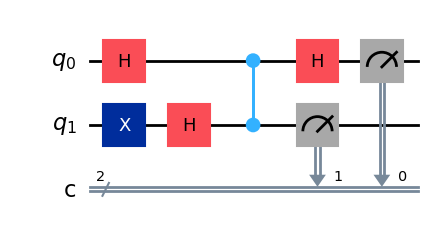

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 25

[Generation 40] Best Fitness: 0.4805


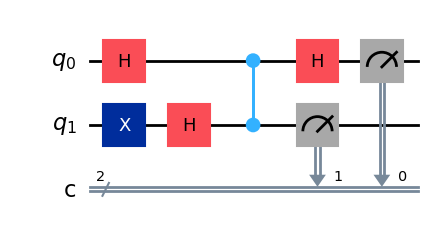

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 36

[Generation 41] Best Fitness: 0.4805


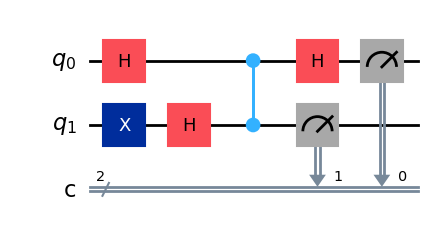

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 23

[Generation 42] Best Fitness: 0.4805


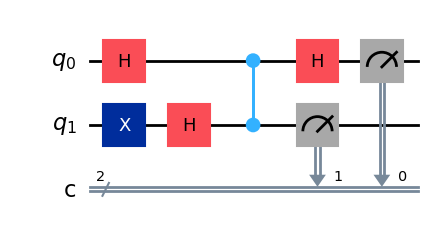

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.48046875,) , Number of invalids = 30

[Generation 43] Best Fitness: 0.4805


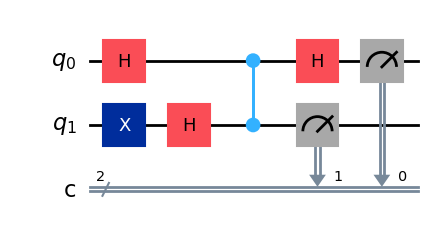

gen = 0 , Best fitness = (0.48046875,)
gen = 1 , Best fitness = (0.4794921875,) , Number of invalids = 27

[Generation 44] Best Fitness: 0.4795


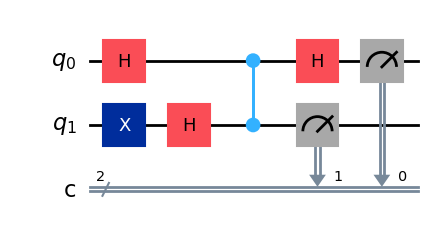

gen = 0 , Best fitness = (0.4794921875,)
gen = 1 , Best fitness = (0.4794921875,) , Number of invalids = 31

[Generation 45] Best Fitness: 0.4795


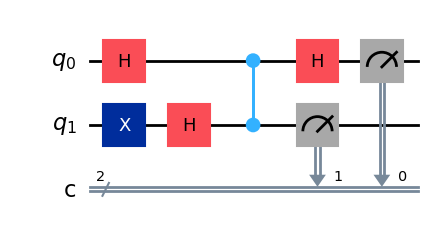

gen = 0 , Best fitness = (0.4794921875,)
gen = 1 , Best fitness = (0.4794921875,) , Number of invalids = 26

[Generation 46] Best Fitness: 0.4795


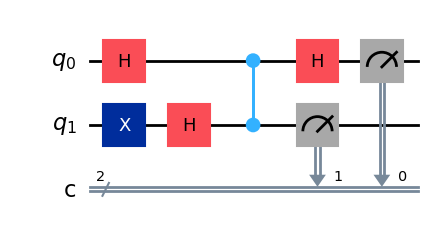

gen = 0 , Best fitness = (0.4794921875,)
gen = 1 , Best fitness = (0.4794921875,) , Number of invalids = 19

[Generation 47] Best Fitness: 0.4795


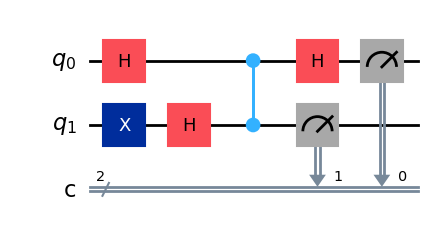

gen = 0 , Best fitness = (0.4794921875,)
gen = 1 , Best fitness = (0.4794921875,) , Number of invalids = 22

[Generation 48] Best Fitness: 0.4795


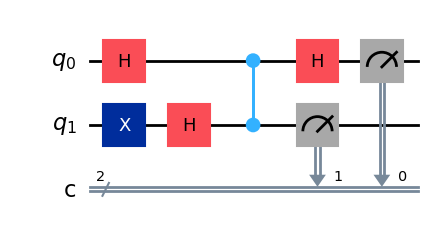

gen = 0 , Best fitness = (0.4794921875,)
gen = 1 , Best fitness = (0.4794921875,) , Number of invalids = 30

[Generation 49] Best Fitness: 0.4795


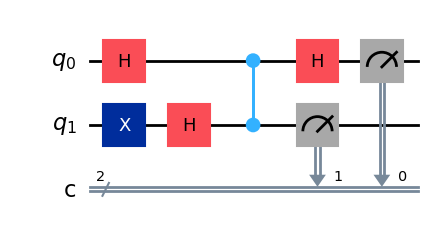

In [11]:
population = toolbox.populationCreator(pop_size=POPULATION_SIZE)
hof = tools.HallOfFame(HALLOFFAME_SIZE)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# We'll store the logbook from the final generation in this variable.
final_logbook = None

# Evolve one generation at a time and visualize the best circuit each generation
for gen in range(MAX_GENERATIONS):
    # Evolve one generation (ngen=1)
    population, logbook_gen = algorithms.ge_eaSimpleWithElitism(
        population,
        toolbox,
        cxpb=P_CROSSOVER,
        mutpb=P_MUTATION,
        ngen=1,  # run one generation at a time
        elite_size=ELITE_SIZE,
        bnf_grammar=BNF_GRAMMAR,
        codon_size=CODON_SIZE,
        max_tree_depth=MAX_TREE_DEPTH,
        max_genome_length=None,
        codon_consumption=CODON_CONSUMPTION,
        report_items=["gen", "min", "max", "avg", "std"],
        genome_representation=GENOME_REPRESENTATION,
        stats=stats,
        halloffame=hof,
        verbose=False
    )
    final_logbook = logbook_gen  # Save the current generation logbook

    # Select the best individual of this generation
    best_ind = tools.selBest(population, 1)[0]
    best_code = evaluator.decode_individual(best_ind)
    best_circuit = evaluator.code_to_circuit(best_code)
    
    # Print fitness and display the circuit drawing
    print(f"\n[Generation {gen}] Best Fitness: {best_ind.fitness.values[0]:.4f}")
    if best_circuit:
        display(best_circuit.draw("mpl"))
    else:
        print("Best individual could not be decoded into a valid circuit.")


[HALL OF FAME]
Individual 1:
Genome: [268, 275, 59, 49, 301, 247, 247, 183, 239, 202, 386, 6]
Phenotype: "qc = QuantumCircuit(2, 2)\n" "qc.x(1)\n" "qc.h(0)\n" "qc.h(1)\n" "## Oracle start\n" "qc.cz(" "1,0" ")\n" "## Oracle end\n" "qc.h(0)\n" "qc.measure(0,0)\n" "qc.measure(1, 1)\n"
Fitness: 0.4794921875

--- Oracle: constant0 ---
Classification: balanced
Counts: {'11': 0.501953125, '00': 0.498046875}


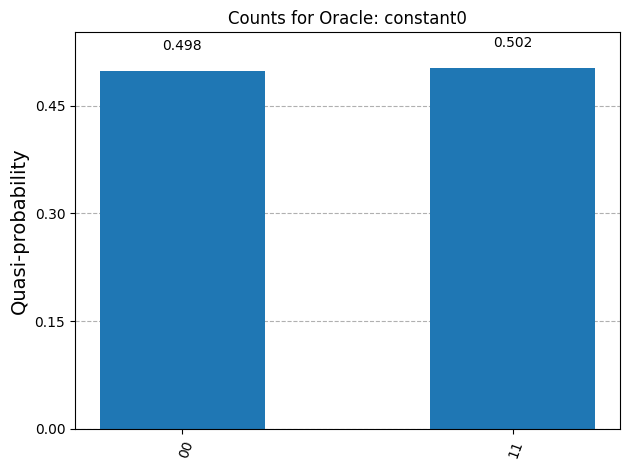


--- Oracle: constant1 ---
Classification: constant
Counts: {'00': 0.509765625, '11': 0.490234375}


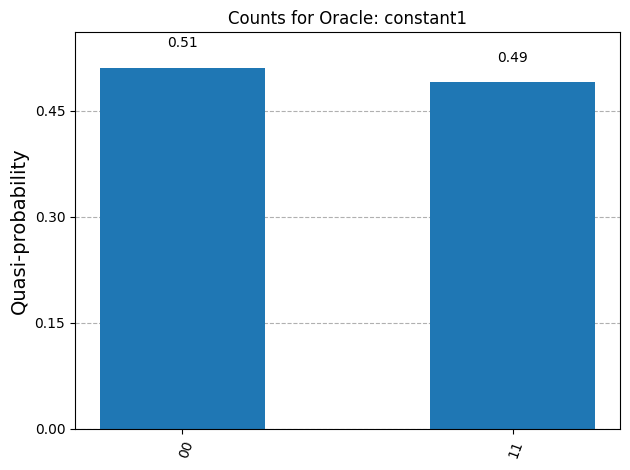


--- Oracle: balanced0to1 ---
Classification: balanced
Counts: {'00': 0.4892578125, '11': 0.5107421875}


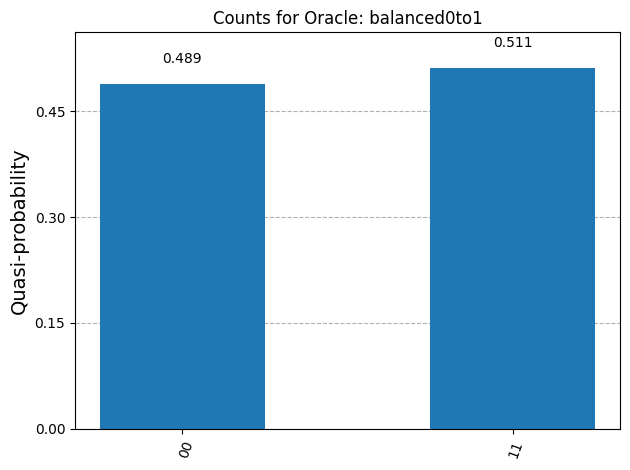


--- Oracle: balanced1to0 ---
Classification: balanced
Counts: {'11': 0.5048828125, '00': 0.4951171875}


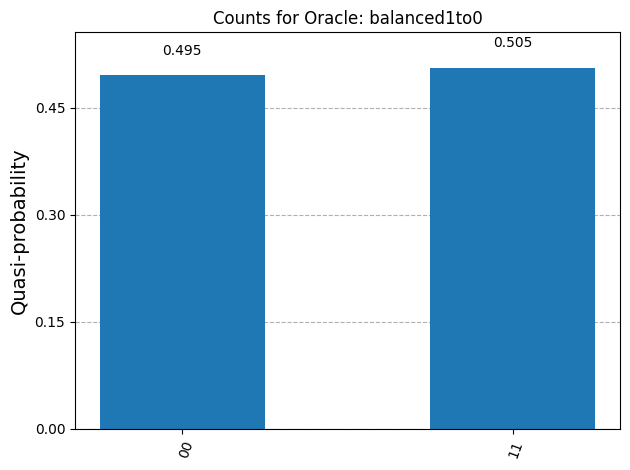

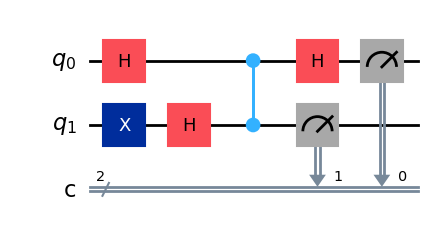


Best Individual's Fitness: 0.4794921875


In [12]:
print("\n[HALL OF FAME]")
for i, hof_ind in enumerate(hof.items):
    print(f"Individual {i+1}:")
    print(f"Genome: {hof_ind.genome}")
    print(f"Phenotype: {hof_ind.phenotype}")
    print(f"Fitness: {hof_ind.fitness.values[0]}")

# Decode the best individual from the hall of fame
best_ind = hof.items[0]
best_phenotype = evaluator.decode_individual(best_ind)
best_circuit = evaluator.code_to_circuit(best_phenotype)

# Evaluate and log performance for each oracle
if best_circuit is not None:
    for oracle_name, oracle_fn in ORACLES.items():
        print(f"\n--- Oracle: {oracle_name} ---")
        qc_test = best_circuit.copy()
        oracle_fn(qc_test)
        counts = get_measurement_probabilities(qc_test)
        classification = classify_circuit(counts, threshold=evaluator.threshold)
        print(f"Classification: {classification}")
        print(f"Counts: {counts}")
        display(plot_histogram(counts, title=f"Counts for Oracle: {oracle_name}"))
else:
    print("Best individual could not be decoded into a valid circuit.")

# Display the best circuit's drawing
if best_circuit:
    display(best_circuit.draw("mpl"))
else:
    print("The best individual could not be decoded into a valid circuit.")

print("\nBest Individual's Fitness:", best_ind.fitness.values[0])


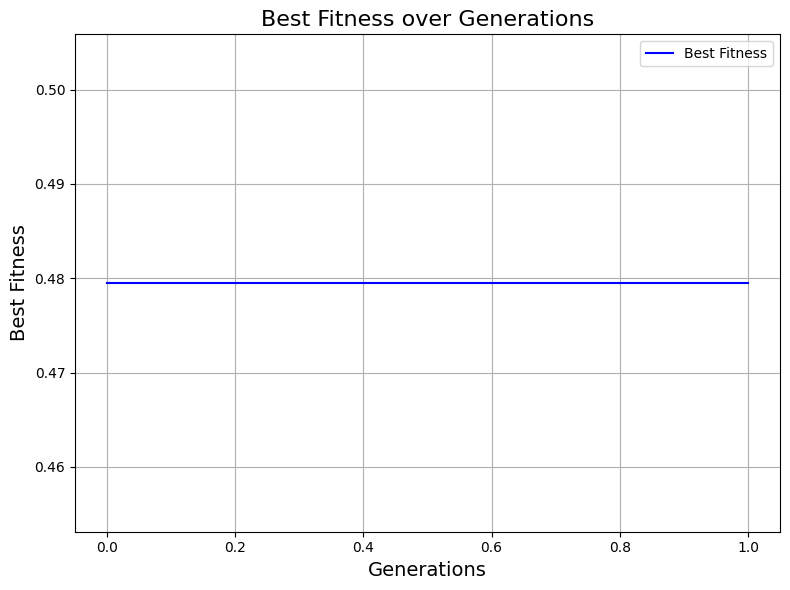

In [13]:
generations = final_logbook.select("gen")
min_fitness_values = final_logbook.select("min")

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(generations, min_fitness_values, 'b-', label="Best Fitness")
ax.set_xlabel('Generations', fontsize=14)
ax.set_ylabel('Best Fitness', fontsize=14)
ax.set_title('Best Fitness over Generations', fontsize=16)
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

In [14]:
best_phenotype = evaluator.decode_individual(best_ind)
best_circuit_base = evaluator.code_to_circuit(best_phenotype)

if best_circuit_base is not None:
    for oracle_name, oracle_fn in ORACLES.items():
        qc_test = best_circuit_base.copy()
        oracle_fn(qc_test)
        probs = get_measurement_probabilities(qc_test)
        classification = classify_circuit(probs, threshold=0.48)
        expected = "constant" if oracle_name.startswith("constant") else "balanced"
        print(f"Oracle: {oracle_name}, Expected: {expected}, Classified as: {classification}")
        if classification != expected:
            print("    -> Incorrect classification!")
else:
    print("Best individual could not be decoded into a valid circuit.")

Oracle: constant0, Expected: constant, Classified as: constant
Oracle: constant1, Expected: constant, Classified as: constant
Oracle: balanced0to1, Expected: balanced, Classified as: constant
    -> Incorrect classification!
Oracle: balanced1to0, Expected: balanced, Classified as: constant
    -> Incorrect classification!
